In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

cols = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration', 'num_of_doors', 'body_style', \
       'drive_wheels', 'engine_location', 'wheel_base', 'length', 'width', 'height', 'curb_weight', \
       'engine_type', 'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke', 'compression', \
       'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
cars = pd.read_csv('data/imports-85.data', header=None, names=cols)
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


The included dataset does not include headers. We have to refer to the source of the data for the column names. Thankfully the columns line up nicely with the provided data.

The source of this dataset with definitions can be foudn here: https://archive.ics.uci.edu/ml/datasets/automobile

In [2]:
cars.dtypes

symboling              int64
normalized_losses     object
make                  object
fuel_type             object
aspiration            object
num_of_doors          object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_of_cylinders      object
engine_size            int64
fuel_system           object
bore                  object
stroke                object
compression          float64
horsepower            object
peak_rpm              object
city_mpg               int64
highway_mpg            int64
price                 object
dtype: object

With the column headings loaded in, next we should check the data types to see if the data types are correct.

If we compare the dictionary, we can identify that these columns should be converted
2. normalized-losses - Should be int
6. num-of-doors - Is string, but values are written out. Can convert to int
16. num-of-cylinders - Is string, but values are written out. Can convert to int
19. bore - Should be numeric
20. stroke - Should be numeric
21. compression - Classified as numeric, but dictionary indicates that it might be an int
22. horsepower - Should be numeric or int
23. peak-rpm - Should be numeric or int
26. price - Should be numeric, maybe int if all values are whole currency units

Somes values we'll have to take a quick peek using unique() or other selection methods. Some observations:
- bore, stroke have ? in them that prevented Pandas from loading these columns with the correct data type
- compression is okay. It was unclear with the min/max range listed whether it could be an integer or not, but an examination of the unique values reveals that clearly that there are decimal places
- horsepower, peak_rpm, city_mpg, and highway_mpg should all be int. Like bore and stroke, it has a `?`. We do need to keep in mind that these columns should be converted to an int instead of a numeric
- While it's not uncommon for price columns to have decimal places, the price column in this dataset appears to be all whole numbers. This column can be converted with the above group

In [3]:
# first step, let's get rid of the question marks and replace them with blanks
cars = cars.replace('?', np.nan)
cars['horsepower'].unique()
to_numeric_cols = ['bore', 'stroke', 'compression']
to_int_cols = ['normalized_losses', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']

test1 = [pd.to_numeric(cars[col], errors='coerce', downcast='float') for col in to_numeric_cols]
test2 = [pd.to_numeric(cars[col], errors='coerce', downcast='integer') for col in to_int_cols]
for col in to_numeric_cols:
    cars[col] = pd.to_numeric(cars[col], errors='coerce', downcast='float')

for col in to_int_cols:
    cars[col] = pd.to_numeric(cars[col], errors='coerce', downcast='integer')
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


To convert `num_of_doors` and `num_of_cylinders`, we'll need to use a dictionary to match the word to the numeral. We can get away with manually specifiying the dictionary because there are a limited number of unique values. We encapsulate this in a try/catch block because NaN values will return an error.

Note that by using NaN, this will make some columns incompatible with an integer dtype. It is probably okay to use 0 as a substitute for NaN, but my general preference is to use a `NaN` or `None` type whenever we aren't completely certain of the data type

In [4]:
word_to_num = {'two':2, 'three':3, 'four':4, 'five':5, 'six':6, 'seven':7, 'eight':8, 'nine':9, 'ten':10, 'eleven':11, 'twelve':12}

def word_to_number(word):
    try:
        return word_to_num[word]
    except:
        return np.nan

number_word_cols = ['num_of_doors', 'num_of_cylinders']
for col in number_word_cols:
    cars[col] = pd.to_numeric(cars[col].apply(word_to_number), errors='coerce', downcast='integer')

In [5]:
cars.dtypes

symboling              int64
normalized_losses    float64
make                  object
fuel_type             object
aspiration            object
num_of_doors         float64
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_of_cylinders        int8
engine_size            int64
fuel_system           object
bore                 float32
stroke               float32
compression          float32
horsepower           float64
peak_rpm             float64
city_mpg                int8
highway_mpg             int8
price                float64
dtype: object

Okay! It's pretty clear that the `price` column is our target for this project. It may be possible to use an MPG column as a predictor if a buyer is looking to buy a car with a certain MPG.

There are a good amount of numerical columns in this set that we can use for feature columns. MPG, horsepower, columns related to size, and the number of doors/cylinders look like they can be good candidates for features.

I'm not enough of a mechanic to understand some other columns, such as normalized_losses, or symboling, or compression. Additional research would be needed in order to conclusively determine if they can be used.

Finally, let's also normalized the `normalized_losses` column.

In [6]:
rescaler = preprocessing.MinMaxScaler()
normalized_losses = cars[['normalized_losses']]
scaled = rescaler.fit_transform(normalized_losses)
cars['normalized_losses'] = scaled
#print(cars['normalized_losses'])

# the model does not like NaN values in inputs
cars = cars.dropna()
cars.shape

(159, 26)

In [7]:
def knn_train_test(train_cols, target_col, data, k):
    # performs a K Neighbors regression and returns the mse
    train_rows = int(round(data.shape[0]*.75, 0))
    train = data.iloc[:train_rows]
    test = data.iloc[train_rows:]
    
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train[train_cols], train[target_col])
    predictions = knn.predict(test[train_cols])

    return mean_squared_error(test[target_col], predictions)**.5

rmse = knn_train_test(['city_mpg'], ['price'], cars, 5)
# this model does not seem to like NaN values which are still in our dataset
numeric_feat_cols = ['normalized_losses', 'num_of_doors', 'wheel_base', 'length', 'width', 'height',
                'curb_weight', 'num_of_cylinders', 'engine_size', 'bore', 'stroke', 'compression',
               'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg']

results = {}
for col in numeric_feat_cols:
    rmse = knn_train_test([col], ['price'], cars, 5)
    results[col] = rmse
    
[print(key, ":", value) for key, value in results.items()]

normalized_losses : 7163.454380325179
num_of_doors : 4596.518074042568
wheel_base : 2780.5685197455573
length : 3743.6411554795154
width : 3255.613799731166
height : 5424.914824308305
curb_weight : 2382.012942660052
num_of_cylinders : 4096.305867485972
engine_size : 3533.611245737142
bore : 5300.910054132215
stroke : 7260.7657035604725
compression : 5547.402673053399
horsepower : 3944.6014507171694
peak_rpm : 5893.609675063322
city_mpg : 3595.7557442073285
highway_mpg : 2827.8504514913793


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

The curb weight seems to have the lowest RMSE. However, all of these values are quite high, indicating that one variable alone isn't a good predictor of price.

Let's run a bunch of tests using all of the k values.

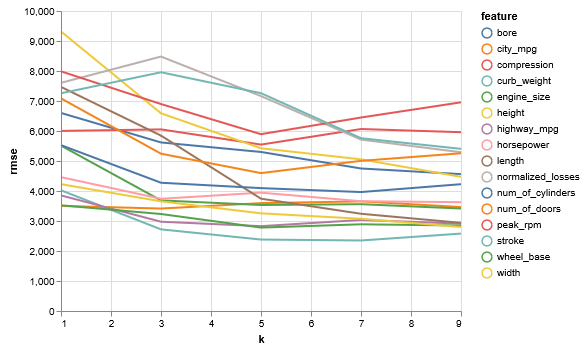

In [10]:
import altair as alt
alt.renderers.enable('notebook')

k_values = [1, 3, 5, 7, 9]
numeric_feat_cols.sort(key=str.lower)

col_list = []
rmse_list = []
k_list = []

for k in k_values:
    rmses = []
    for col in numeric_feat_cols:
        rmse = knn_train_test([col], ['price'], cars, k)
        rmse_list.append(rmse)
        col_list.append(col)
        k_list.append(k)
        
results_df = pd.DataFrame()
results_df['feature'] = col_list
results_df['k'] = k_list
results_df['rmse'] = rmse_list

alt.Chart(results_df).mark_line().encode(
    x='k',
    y='rmse',
    color='feature'
)

In [28]:
results_df.groupby('k').mean()

,rmse
k,
1,5872.787100
3,5024.522263
5,4459.221035
7,4264.459576
9,4170.000440


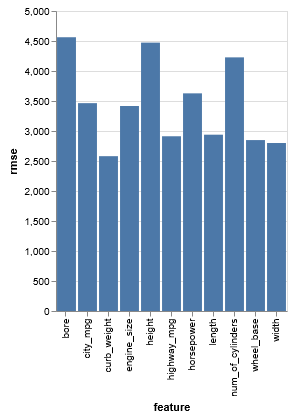

In [23]:
ff = results_df[(results_df['k']==9)&(results_df['rmse']<5000)]
alt.Chart(ff).mark_bar().encode(
    x='feature',
    y='rmse'
)

In [27]:
results_df.sort_values('rmse').head()

,feature,k,rmse
51,curb_weight,7,2350.833036
35,curb_weight,5,2382.012943
67,curb_weight,9,2580.379796
19,curb_weight,3,2721.320027
46,wheel_base,5,2780.568520


All values of k used still give us a rather high RMSE. Sorting our results by the lowest RMSE show us that curb weight has the lowest RMSE overall. The minimum RMSE occurs with a k value of 7, although a k value of 9 contains the lowest average RMSE among all features.